# Final Project Submission

* Student name: Jonathan Vasquez
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: Fangfang Lee, SeanAbu Wilson, Matthew Wasserman
* Blog post URL:

# Importing Libraries

In [1]:
from __future__ import print_function
import rdkit
import os

import collections

from rdkit import Chem, RDConfig 
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, rdMolDescriptors

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


from sklearn import metrics

from sklearn.metrics import accuracy_score, f1_score, recall_score, make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint

from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.utils import resample

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Context

The 2014 Tox21 data challenge is designed to help scientists understand the potential of the chemicals and compounds being tested through the Toxicology in the 21st Century initiative to disrupt biological pathways in ways that may result in toxic effects. The goal of the challenge is to "crowdsource" data analysis by independent researchers to reveal how well they can predict compounds' interference in biochemical pathways using only chemical structure data. The computational models produced from the Challenge could become decision-making tools for government agencies in determining which environmental chemicals and drugs are of the greatest potential concern to human health.

The Tox21 dataset comprises of 7831 molecule and for each molecule there are 12 binary labels that represent the outcome (active/inactive) of 12 different toxicological experiments. Note that the label matrix contains many missing values (NAs). The original data source and Tox21 challenge site is https://tripod.nih.gov/tox21/challenge/.

Androgen receptor (AR), a nuclear hormone receptor, plays a critical role in AR-dependent prostate cancer and other androgen related diseases. Thus, AR is an important therapeutic target in prostate cancer. 

The simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical entity.

# Importing Data

In [2]:
df = pd.read_csv('tox21/tox21.csv')
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


# EDA

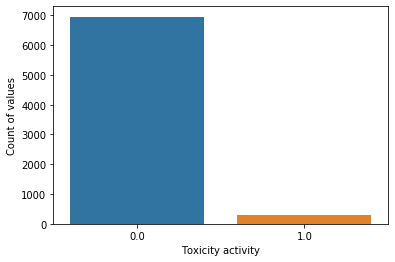

In [3]:
#Let's look at the target values count
sns.countplot(data = df, x='NR-AR', orient='v')
plt.ylabel('Count of values')
plt.xlabel('Toxicity activity')
plt.show()

# Data Cleaning/Feature Engineering

In [4]:
#Transform SMILES to MOL
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

#Extracting descriptors

# TPSA method extracts the topological polar surface area of a molecule
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))

# Mol_W method returns the molecular weight of a molecule
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))

# Number of Valence Electrons method returns the number of electrons in the outer shell of a molecule
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))

# Heteroatoms method returns the number of atoms in the ring of a cyclic compound other than a carbon atom
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())

# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

# CalcNumAromaticRings method returns the number of aromatic 
df['num_of_arom_rings'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x))

# CalcNumAliphaticRing method returns the number aliphatic rings
df['num_of_aliph_rings'] = df['mol'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticRings(x))

# Get the number of typical organic atoms in each molecule 
def number_of_atoms(atom_list, df): 
    for elmt in atom_list: 
        df['num_of_{}_atoms'.format(elmt)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches
                                                                (Chem.MolFromSmiles(elmt))))
number_of_atoms(['C','O', 'N','P', 'S'], df)

RDKit WARNING: [08:02:11] WARNING: not removing hydrogen atom without neighbors


In [5]:
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,...,num_heteroatoms,num_of_atoms,num_of_heavy_atoms,num_of_arom_rings,num_of_aliph_rings,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_P_atoms,num_of_S_atoms
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,7,26,16,2,0,9,3,2,0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,4,27,15,1,1,11,2,2,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,1,53,21,0,4,20,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,3,48,20,1,0,17,1,2,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,19,11,0,0,2,7,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,9,53,33,5,0,24,3,6,0,0
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,2,53,23,0,4,21,2,0,0,0
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,2,49,21,0,4,19,2,0,0,0
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,...,2,44,20,1,3,18,2,0,0,0


# Dropping Non Androgen Receptor Biological Targets/Pathways

In [6]:
nrar_df = df.drop(columns=[
                     'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
                     'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
                     'SR-HSE', 'SR-MMP', 'SR-p53'])

In [7]:
nrar_df

,NR-AR,mol_id,smiles,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_atoms,num_of_heavy_atoms,num_of_arom_rings,num_of_aliph_rings,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_P_atoms,num_of_S_atoms
0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,"<img data-content=""rdkit/molecule"" src=""data:i...",82.28,258.013284,86,7,26,16,2,0,9,3,2,0,2
1,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,"<img data-content=""rdkit/molecule"" src=""data:i...",49.41,204.089878,78,4,27,15,1,1,11,2,2,0,0
2,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,"<img data-content=""rdkit/molecule"" src=""data:i...",20.23,288.245316,118,1,53,21,0,4,20,1,0,0,0
3,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,"<img data-content=""rdkit/molecule"" src=""data:i...",32.34,276.220164,112,3,48,20,1,0,17,1,2,0,0
4,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",135.29,205.974526,68,9,19,11,0,0,2,7,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,"<img data-content=""rdkit/molecule"" src=""data:i...",118.81,440.159689,164,9,53,33,5,0,24,3,6,0,0
7827,1.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,"<img data-content=""rdkit/molecule"" src=""data:i...",34.14,314.224580,126,2,53,23,0,4,21,2,0,0,0
7828,1.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,"<img data-content=""rdkit/molecule"" src=""data:i...",37.30,288.208930,116,2,49,21,0,4,19,2,0,0,0
7829,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,"<img data-content=""rdkit/molecule"" src=""data:i...",40.46,272.177630,108,2,44,20,1,3,18,2,0,0,0


# Viewing the NaNs

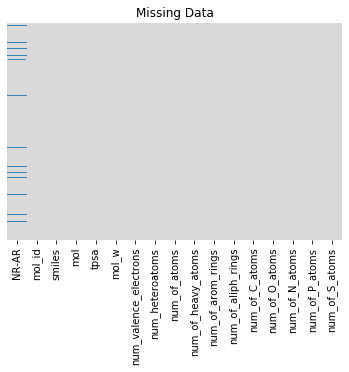

In [8]:
#Visual Showing Missing Values
sns.heatmap(nrar_df.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

In [9]:
nrar_df['NR-AR'].value_counts()

0.0    6956
1.0     309
Name: NR-AR, dtype: int64

# Dropping the NaN's

In [10]:
nrar_df.dropna(inplace=True)

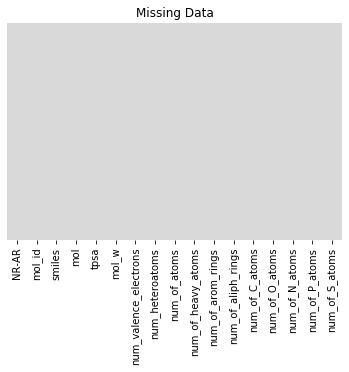

In [11]:
#Visual Showing No Missing Values
sns.heatmap(nrar_df.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

# Resetting the Index

In [12]:
nrar_df.reset_index(drop=True, inplace=True)

In [13]:
nrar_df

,NR-AR,mol_id,smiles,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_atoms,num_of_heavy_atoms,num_of_arom_rings,num_of_aliph_rings,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_P_atoms,num_of_S_atoms
0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,"<img data-content=""rdkit/molecule"" src=""data:i...",82.28,258.013284,86,7,26,16,2,0,9,3,2,0,2
1,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,"<img data-content=""rdkit/molecule"" src=""data:i...",49.41,204.089878,78,4,27,15,1,1,11,2,2,0,0
2,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,"<img data-content=""rdkit/molecule"" src=""data:i...",32.34,276.220164,112,3,48,20,1,0,17,1,2,0,0
3,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",135.29,205.974526,68,9,19,11,0,0,2,7,0,2,0
4,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,"<img data-content=""rdkit/molecule"" src=""data:i...",36.92,290.245710,122,4,54,20,0,0,16,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,0.0,TOX25184,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,"<img data-content=""rdkit/molecule"" src=""data:i...",58.56,341.199094,134,4,52,25,2,0,21,3,1,0,0
7261,1.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,"<img data-content=""rdkit/molecule"" src=""data:i...",34.14,314.224580,126,2,53,23,0,4,21,2,0,0,0
7262,1.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,"<img data-content=""rdkit/molecule"" src=""data:i...",37.30,288.208930,116,2,49,21,0,4,19,2,0,0,0
7263,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,"<img data-content=""rdkit/molecule"" src=""data:i...",40.46,272.177630,108,2,44,20,1,3,18,2,0,0,0


# Setting Index to SMILES

In [14]:
nrar_df.set_index('smiles', inplace=True)

In [15]:
nrar_df

,NR-AR,mol_id,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_atoms,num_of_heavy_atoms,num_of_arom_rings,num_of_aliph_rings,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_P_atoms,num_of_S_atoms
smiles,,,,,,,,,,,,,,,,
CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,TOX3021,"<img data-content=""rdkit/molecule"" src=""data:i...",82.28,258.013284,86,7,26,16,2,0,9,3,2,0,2
CCN1C(=O)NC(c2ccccc2)C1=O,0.0,TOX3020,"<img data-content=""rdkit/molecule"" src=""data:i...",49.41,204.089878,78,4,27,15,1,1,11,2,2,0,0
CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,TOX3027,"<img data-content=""rdkit/molecule"" src=""data:i...",32.34,276.220164,112,3,48,20,1,0,17,1,2,0,0
CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,TOX20800,"<img data-content=""rdkit/molecule"" src=""data:i...",135.29,205.974526,68,9,19,11,0,0,2,7,0,2,0
CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,TOX5110,"<img data-content=""rdkit/molecule"" src=""data:i...",36.92,290.245710,122,4,54,20,0,0,16,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0.0,TOX25184,"<img data-content=""rdkit/molecule"" src=""data:i...",58.56,341.199094,134,4,52,25,2,0,21,3,1,0,0
CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C,1.0,TOX2370,"<img data-content=""rdkit/molecule"" src=""data:i...",34.14,314.224580,126,2,53,23,0,4,21,2,0,0,0
C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O,1.0,TOX2371,"<img data-content=""rdkit/molecule"" src=""data:i...",37.30,288.208930,116,2,49,21,0,4,19,2,0,0,0


# Heatmap

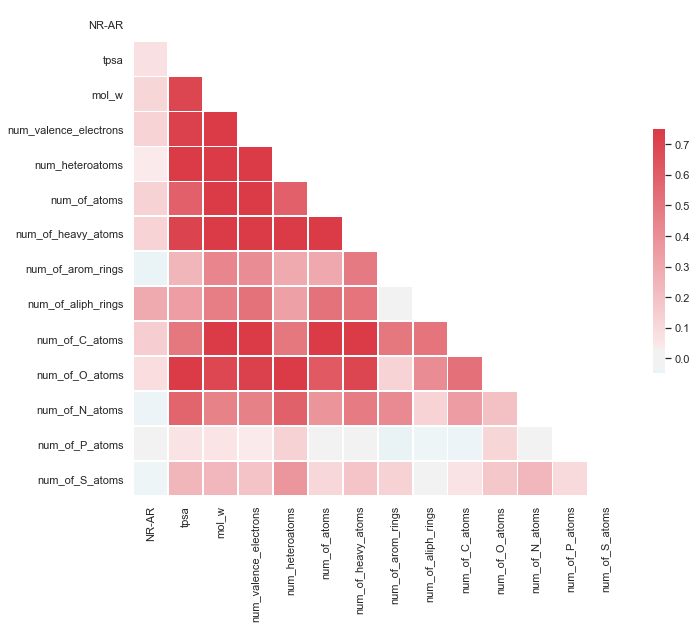

In [16]:
#Heatmap to Visualize Correlations
sns.set(style="white")
corr = nrar_df.corr() 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Establishing Target, Features, & Train Test Split

In [17]:
target = nrar_df['NR-AR']
features = nrar_df.select_dtypes(include=['number']).drop(columns='NR-AR')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [19]:
scaler= StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

# Confusion Matrix

In [20]:
# function to build a confusion matrix visualization
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Logisitic Regression

In [21]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
logreg_f1 = metrics.f1_score(y_test, logreg_preds)
logreg_acc = metrics.accuracy_score(y_test, logreg_preds)
print('Test F1:' , logreg_f1)
print('Test Accuracy:' , logreg_acc)

Test F1: 0.23786407766990292
Test Accuracy: 0.8271876719867914


Confusion matrix, without normalization
[[1454  283]
 [  31   49]]


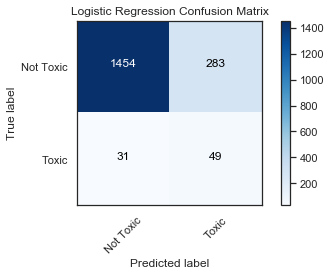

In [22]:
cm_lr=metrics.confusion_matrix(y_test, logreg_preds)
plot_confusion_matrix(cm_lr, classes=['Not Toxic', 'Toxic'], title='Logistic Regression Confusion Matrix')

In [23]:
collections.Counter(logreg_preds)

Counter({0.0: 1485, 1.0: 332})

# Dealing With Class Imbalance via Upsampling

In [24]:
from sklearn.utils import resample

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_toxic = X[X['NR-AR']==0]
toxic = X[X['NR-AR']==1]

# upsample minority
toxic_upsampled = resample(toxic,
                          replace=True, # sample with replacement
                          n_samples=len(not_toxic), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_toxic, toxic_upsampled])

# check new class counts
upsampled['NR-AR'].value_counts()

1.0    5219
0.0    5219
Name: NR-AR, dtype: int64

# Logistic Regression - Upsampled

In [25]:
# trying logistic regression again with the balanced dataset
y_train = upsampled['NR-AR']
X_train = upsampled.drop(('NR-AR'), axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

# Checking accuracy
print('Test Accuracy:' , accuracy_score(y_test, upsampled_pred))
    
# F1 score
print('Test F1:' , f1_score(y_test, upsampled_pred))

# Recall
print('Test Recall:' , recall_score(y_test, upsampled_pred))

Test Accuracy: 0.8304898183819482
Test F1: 0.2376237623762376
Test Recall: 0.6


Confusion matrix, without normalization
[[1461  276]
 [  32   48]]


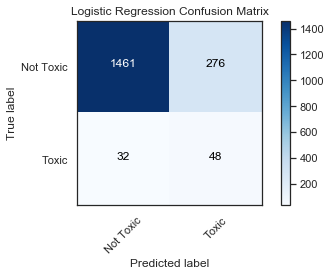

In [26]:
cm_lr=metrics.confusion_matrix(y_test, upsampled_pred)
plot_confusion_matrix(cm_lr, classes=['Not Toxic', 'Toxic'], title='Logistic Regression Confusion Matrix')

In [27]:
collections.Counter(upsampled_pred)

Counter({0.0: 1493, 1.0: 324})

# SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = nrar_df['NR-AR']
X = nrar_df.select_dtypes(include=['number']).drop(columns='NR-AR')

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [29]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

# Checking accuracy
print('Test Accuracy:' , accuracy_score(y_test, smote_pred))
    
# F1 score
print('Test F1:' , f1_score(y_test, smote_pred))

# Recall
print('Test Recall:' , recall_score(y_test, smote_pred))

Test Accuracy: 0.9201981287837094
Test F1: 0.36123348017621143
Test Recall: 0.5125


Confusion matrix, without normalization
[[1631  106]
 [  39   41]]


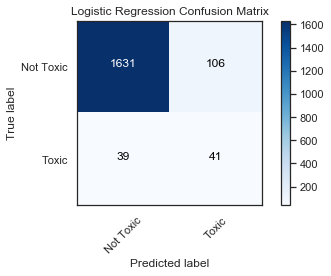

In [30]:
cm_lr=metrics.confusion_matrix(y_test, smote_pred)
plot_confusion_matrix(cm_lr, classes=['Not Toxic', 'Toxic'], title='Logistic Regression Confusion Matrix')

In [31]:
collections.Counter(smote_pred)

Counter({0.0: 1670, 1.0: 147})

# ADASYN

In [257]:
from imblearn.over_sampling import ADASYN

In [258]:
ada = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5, n_jobs=-1)

# Separate input features and target
y = nrar_df['NR-AR']
X = nrar_df.select_dtypes(include=['number']).drop(columns='NR-AR')

X_res, y_res = ada.fit_resample(X,y)

In [259]:
print('Oversampled Target Variable Distribution:', collections.Counter(y_res))

Oversampled Target Variable Distribution: Counter({1.0: 6973, 0.0: 6956})


In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
import warnings 

warnings.filterwarnings("ignore")

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_res, y_res, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.831501 (0.022466)
LDA: 0.852963 (0.062639)
KNN: 0.814777 (0.030089)
CART: 0.880176 (0.042351)
NB: 0.681669 (0.044156)
SVM: 0.623590 (0.032848)


# KNN

In [32]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn)
knn_acc = metrics.accuracy_score(y_test, y_pred_knn)
print('Test F1:' + str(knn_f1))
print('Test Accuracy:' + str(knn_acc))

Test F1:0.1979695431472081
Test Accuracy:0.8260869565217391


Confusion matrix, without normalization
[[1462  275]
 [  41   39]]


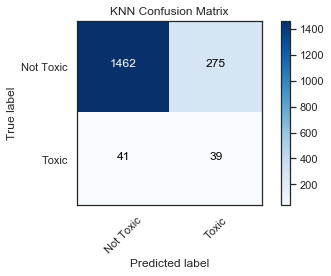

In [33]:
cm_knn=metrics.confusion_matrix(y_test,y_pred_knn)
plot_confusion_matrix(cm_knn, classes=['Not Toxic', 'Toxic'], title='KNN Confusion Matrix')

In [34]:
collections.Counter(y_pred_knn)

Counter({0.0: 1503, 1.0: 314})

# Decision Tree

In [35]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_f1 = metrics.f1_score(tree_pred, y_test)
tree_acc = metrics.accuracy_score(tree_pred, y_test)
print('Test F1 score: ', tree_f1)
print('Test Accuracy score: ', tree_acc)

Test F1 score:  0.1786492374727669
Test Accuracy score:  0.7925151348376445


Confusion matrix, without normalization
[[1399  338]
 [  39   41]]


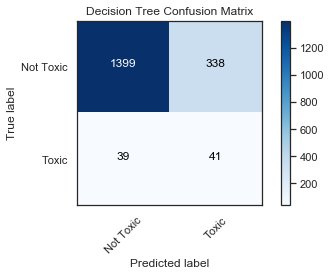

In [36]:
cm_dt=metrics.confusion_matrix(y_test,tree_pred)
plot_confusion_matrix(cm_dt, classes=['Not Toxic', 'Toxic'], title='Decision Tree Confusion Matrix')

In [37]:
collections.Counter(tree_pred)

Counter({0.0: 1438, 1.0: 379})

# Random Forest

In [38]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators = 100)
forest.fit(X_train, y_train)
forest_preds = forest.predict(X_test)
forest_f1 = metrics.f1_score(y_test, forest_preds)
forest_acc = metrics.accuracy_score(y_test, forest_preds)
print('Test F1 score: ', forest_f1)
print('Test Accuracy score: ', forest_acc)

Test F1 score:  0.3975903614457831
Test Accuracy score:  0.9449642267473858


Confusion matrix, without normalization
[[1684   53]
 [  47   33]]


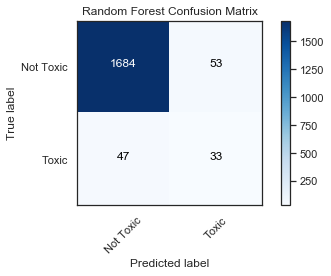

In [39]:
cm_rf=metrics.confusion_matrix(y_test,forest_preds)
plot_confusion_matrix(cm_rf, classes=['Not Toxic', 'Toxic'], title='Random Forest Confusion Matrix')

In [40]:
collections.Counter(forest_preds)

Counter({0.0: 1731, 1.0: 86})

# GridCV - LogisticRegression

In [270]:
#Creating Dictionary of Parameters to Tune
logistic_param = { 
    'C':[0.01,0.1,1],
    'penalty':['l2']
}

In [271]:
lr_CV = LogisticRegression(random_state = 1)

In [272]:
#Creating Grid Search Object and Fitting to Data
lr_CV = GridSearchCV(estimator=lr_CV, param_grid=logistic_param, cv= 5, scoring='accuracy', verbose=1, n_jobs=-1)
lr_CV.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2']},
             scoring='accuracy', verbose=1)

In [273]:
#Identifying Best Parameters 
print(lr_CV.best_params_)
print(lr_CV.best_estimator_)
#Identifying Best Score During Fitting with Cross-Validation
print(lr_CV.best_score_)

{'C': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1, random_state=1)
0.8758382029237737


In [274]:
#Predicting Test Set
test_preds_lr_CV = lr_CV.best_estimator_.predict(X_test)
#Checking Accuracy and F1 scores
print("F1:",metrics.f1_score(y_test, test_preds_lr_CV))
print("Accuracy:",metrics.accuracy_score(y_test, test_preds_lr_CV))

F1: 0.28
Accuracy: 0.8811227297743534


Confusion matrix, without normalization
[[1559  178]
 [  38   42]]


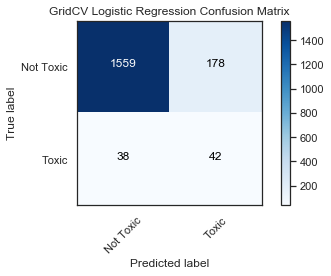

In [275]:
cm_lr_cv=metrics.confusion_matrix(y_test,test_preds_lr_CV)
plot_confusion_matrix(cm_lr_cv, classes=['Not Toxic', 'Toxic'], title='GridCV Logistic Regression Confusion Matrix')

In [276]:
collections.Counter(test_preds_lr_CV)

Counter({0.0: 1597, 1.0: 220})

# GridCV - RF

In [277]:
forest_params = { 
    'n_estimators': [75, 100, 125],
    'max_features': [.25, .35, 'auto'],
    'max_depth' : [7, 9, 11],
    'criterion' : ['entropy']   
}

In [278]:
blank_forest = RandomForestClassifier(random_state = 1)
forest_grid = GridSearchCV(estimator=blank_forest, param_grid=forest_params, cv= 5, scoring='accuracy', verbose=1, n_jobs=-1)
forest_grid.fit(X_train, y_train)
print(forest_grid.best_params_)
print(forest_grid.best_estimator_)
print(forest_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   20.1s finished


{'criterion': 'entropy', 'max_depth': 11, 'max_features': 0.35, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', max_depth=11, max_features=0.35,
                       random_state=1)
0.9546849957867256


In [279]:
best_forest = forest_grid.best_estimator_
bf_preds = best_forest.predict(X_test)
bf_f1 = metrics.f1_score(y_test, bf_preds)
bf_acc = metrics.accuracy_score(y_test, bf_preds)
print('Test F1 score: ', bf_f1)
print('Test Accuracy score: ', bf_acc)

Test F1 score:  0.3255813953488372
Test Accuracy score:  0.9201981287837094


Confusion matrix, without normalization
[[1637  100]
 [  45   35]]


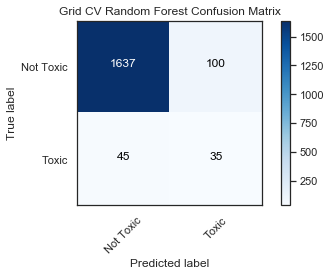

In [280]:
cm_rf_cv=metrics.confusion_matrix(y_test,bf_preds)
plot_confusion_matrix(cm_rf_cv, classes=['Not Toxic', 'Toxic'], title='Grid CV Random Forest Confusion Matrix')

In [281]:
collections.Counter(bf_preds)

Counter({0.0: 1682, 1.0: 135})

# XGBoost

In [282]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds_xgb = clf_xgb.predict(X_train)
val_preds_xgb = clf_xgb.predict(X_test)
training_accuracy_xgb = accuracy_score(y_train, training_preds_xgb)
val_accuracy_xgb = accuracy_score(y_test, val_preds_xgb)
xgb_f1 = metrics.f1_score(val_preds_xgb, y_test)

print("Training Accuracy: {:.4}%".format(training_accuracy_xgb * 100))
print("Validation Accuracy: {:.4}%".format(val_accuracy_xgb * 100))
print("F1 Score: {:.4}%".format(xgb_f1 * 100))

Training Accuracy: 88.72%
Validation Accuracy: 87.84%
F1 Score: 28.01%


Confusion matrix, without normalization
[[1553  184]
 [  37   43]]


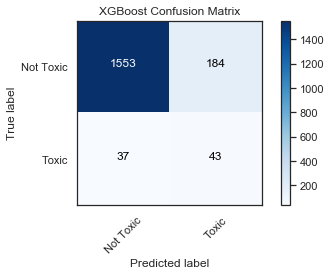

In [283]:
cm_xgb=metrics.confusion_matrix(y_test,val_preds_xgb)
plot_confusion_matrix(cm_xgb, classes=['Not Toxic', 'Toxic'], title='XGBoost Confusion Matrix')

In [284]:
collections.Counter(val_preds_xgb)

Counter({0.0: 1590, 1.0: 227})

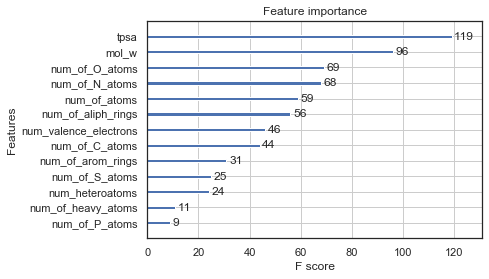

In [285]:
xgb.plot_importance(clf_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# GridCV - XGBoost

In [290]:
param_grid_xgb = {
    "learning_rate": [0.1, 0.2, 0.3, 0.4],
    'max_depth': [7, 9, 12],
    'min_child_weight': [0.5],
    'subsample': [0.5, 1, 2],
    'n_estimators': [95, 105, 110, 115],
}

In [291]:
grid_clf_xgb = GridSearchCV(clf_xgb, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=-1)
grid_clf_xgb.fit(X_train, y_train)

best_parameters = grid_clf_xgb.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds_xgb_cv = grid_clf_xgb.predict(X_train)
val_preds_xgb_cv = grid_clf_xgb.predict(X_test)
training_accuracy_xgb_cv = accuracy_score(y_train, training_preds_xgb_cv)
val_accuracy_xgb_cv = accuracy_score(y_test, val_preds_xgb_cv)
f1_xgb_cv = metrics.f1_score(y_test, val_preds_xgb_cv)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_cv * 100))
print("Validation Accuracy: {:.4}%".format(val_accuracy_xgb_cv * 100))
print("F1 Score: {:.4}%".format(f1_xgb_cv * 100))
print("")
print('Test F1 score: ', f1_xgb_cv)
print('Test Accuracy score: ', val_accuracy_xgb_cv)

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 9
min_child_weight: 0.5
n_estimators: 105
subsample: 1

Training Accuracy: 99.84%
Validation Accuracy: 94.55%
F1 Score: 40.0%

Test F1 score:  0.4
Test Accuracy score:  0.945514584479912


Confusion matrix, without normalization
[[1685   52]
 [  47   33]]


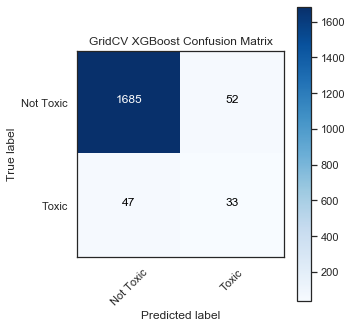

In [292]:
cm_xgb_cv=metrics.confusion_matrix(y_test,val_preds_xgb_cv)
plot_confusion_matrix(cm_xgb_cv, classes=['Not Toxic', 'Toxic'], title='GridCV XGBoost Confusion Matrix')

In [293]:
collections.Counter(val_preds_xgb_cv)

Counter({0.0: 1732, 1.0: 85})

# ADABoost

In [294]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [295]:
training_preds_ada = ada_clf.predict(X_train)
val_preds_ada = ada_clf.predict(X_test)
training_accuracy_ada = accuracy_score(y_train, training_preds_ada)
val_accuracy_ada = accuracy_score(y_test, val_preds_ada)
f1_ada = metrics.f1_score(y_test, val_preds_ada)

print("Training Accuracy: {:.4}%".format(training_accuracy_ada * 100))
print("Validation Accuracy: {:.4}%".format(val_accuracy_ada * 100))
print("")
print('Test F1 score: ', f1_ada)
print('Test Accuracy score: ', val_accuracy_ada)

Training Accuracy: 85.58%
Validation Accuracy: 85.31%

Test F1 score:  0.24788732394366197
Test Accuracy score:  0.8530544854155201


Confusion matrix, without normalization
[[1506  231]
 [  36   44]]


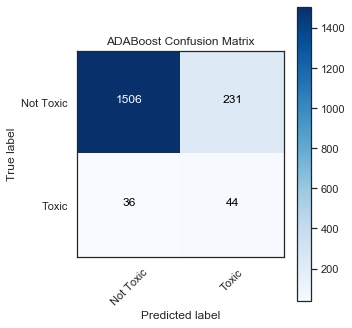

In [296]:
cm_ada=metrics.confusion_matrix(y_test,val_preds_ada)
plot_confusion_matrix(cm_ada, classes=['Not Toxic', 'Toxic'], title='ADABoost Confusion Matrix')

In [297]:
collections.Counter(val_preds_ada)

Counter({0.0: 1542, 1.0: 275})

# VotingClassifier

In [298]:
from sklearn.ensemble import VotingClassifier

In [299]:
voting_clf = VotingClassifier(
                estimators=[('logreg', logreg), ('knneighbors', knn), ('decisiontree', tree), 
                            ('best_randomforest', best_forest), ('adaboost', ada_clf),
                            ('xgboost', grid_clf_xgb)], 
                voting='hard',
                n_jobs=-1)
voting_clf.fit(X_train, y_train)
vc_preds = voting_clf.predict(X_test)
vc_f1 = metrics.f1_score(y_test, vc_preds)
vc_acc = metrics.accuracy_score(y_test, vc_preds)
vc_train_preds = voting_clf.predict(X_train)
vc_train_acc = metrics.accuracy_score(y_train, vc_train_preds)
print('Test F1 score: ', vc_f1)
print('Test Accuracy score: ', vc_acc)
print('Train Accuracy score: ', vc_train_acc)

Test F1 score:  0.37433155080213903
Test Accuracy score:  0.9356081452944414
Train Accuracy score:  0.9846713929871623


Confusion matrix, without normalization
[[1665   72]
 [  45   35]]


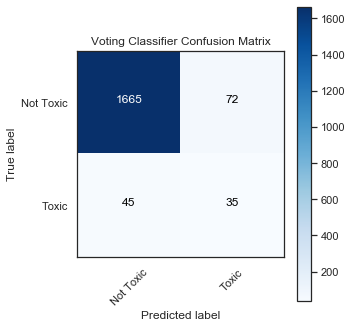

In [300]:
cm_vc=metrics.confusion_matrix(y_test,vc_preds)
plot_confusion_matrix(cm_vc, classes=['Not Toxic', 'Toxic'], title='Voting Classifier Confusion Matrix')

In [301]:
collections.Counter(vc_preds)

Counter({0.0: 1710, 1.0: 107})

# Chemcepterizer 

In [17]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(cmol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

# To View A Specific Molecule of Choice

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 4)


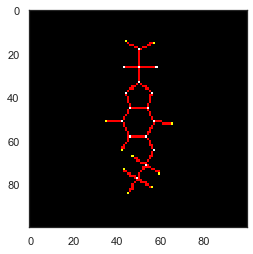

In [50]:
mol = nrar_df['mol'][0]
v = chemcepterize_mol(mol, embed=10, res=0.2)
print(v.shape)
plt.imshow(v[:,:,:3])

# Creating a Vectorized Representation of All Small Molecules

In [19]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=40)
nrar_df["mol_image"] = nrar_df["mol"].apply(vectorize)

In [20]:
nrar_df

,NR-AR,mol_id,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_atoms,num_of_heavy_atoms,num_of_arom_rings,num_of_aliph_rings,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_P_atoms,num_of_S_atoms,mol_image
smiles,,,,,,,,,,,,,,,,,
CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,TOX3021,"<img data-content=""rdkit/molecule"" src=""data:i...",82.28,258.013284,86,7,26,16,2,0,9,3,2,0,2,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
CCN1C(=O)NC(c2ccccc2)C1=O,0.0,TOX3020,"<img data-content=""rdkit/molecule"" src=""data:i...",49.41,204.089878,78,4,27,15,1,1,11,2,2,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,TOX3027,"<img data-content=""rdkit/molecule"" src=""data:i...",32.34,276.220164,112,3,48,20,1,0,17,1,2,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,TOX20800,"<img data-content=""rdkit/molecule"" src=""data:i...",135.29,205.974526,68,9,19,11,0,0,2,7,0,2,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,TOX5110,"<img data-content=""rdkit/molecule"" src=""data:i...",36.92,290.245710,122,4,54,20,0,0,16,4,0,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0.0,TOX25184,"<img data-content=""rdkit/molecule"" src=""data:i...",58.56,341.199094,134,4,52,25,2,0,21,3,1,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C,1.0,TOX2370,"<img data-content=""rdkit/molecule"" src=""data:i...",34.14,314.224580,126,2,53,23,0,4,21,2,0,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O,1.0,TOX2371,"<img data-content=""rdkit/molecule"" src=""data:i...",37.30,288.208930,116,2,49,21,0,4,19,2,0,0,0,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."


# Creating New DF to split Toxic/Not Toxic

In [72]:
nrar_df_toxic = nrar_df[nrar_df['NR-AR'] == 1]
nrar_df_not_toxic = nrar_df[nrar_df['NR-AR'] == 0]

In [100]:
print(len(nrar_df_toxic))
print(len(nrar_df_not_toxic))

309
6956


# Extracting, Separating, & Saving Images into Toxic and Not Toxic Subfolders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


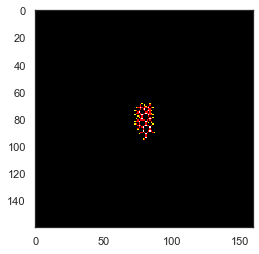

In [87]:
#for index in range(len(nrar_df_toxic['mol_image'])):
#    plt.imshow(nrar_df_toxic["mol_image"][index][:,:,:3])
#    plt.savefig("smiles_images/toxic/"+nrar_df_toxic.iloc[index]['mol_id']+".png", format="png", bbox_inches='tight')

In [ ]:
#for index in range(len(nrar_df_not_toxic['mol_image'])):
#    plt.imshow(nrar_df_not_toxic["mol_image"][index][:,:,:3])
#    plt.savefig("smiles_images/not_toxic/"+nrar_df_not_toxic.iloc[index]['mol_id']+".png", format="png", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

# Plot ROC curve

In [ ]:
dontrun()

In [42]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_model_prob
y_log_prob = logreg.predict_proba(X_test)[:,1]
y_knn_prob = knn.predict_proba(X_test)[:,1]
y_tree_prob = tree.predict_proba(X_test)[:,1]
y_rfc_prob = forest.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_log_prob)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_knn_prob)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_tree_prob)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_rfc_prob)

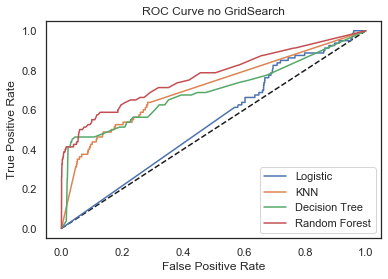

In [43]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log, tpr_log,label = 'Logistic')
plt.plot(fpr_knn, tpr_knn,label = 'KNN')
plt.plot(fpr_tree, tpr_tree,label = 'Decision Tree')
plt.plot(fpr_rfc, tpr_rfc,label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve no GridSearch')
plt.show()

In [44]:
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute and print AUC score
print("AUC Logistic: {}".format(roc_auc_score(y_test, y_log_prob)))
print("AUC KNN: {}".format(roc_auc_score(y_test, y_knn_prob)))
print("AUC Decision Tree: {}".format(roc_auc_score(y_test, y_tree_prob)))
print("AUC Random Forest: {}".format(roc_auc_score(y_test, y_rfc_prob)))

AUC Logistic: 0.5372049510650547
AUC KNN: 0.7078763672999424
AUC Decision Tree: 0.6917170408750719
AUC Random Forest: 0.7695703799654576
